# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


## Data Transformations



In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      #  transforms.RandomErasing()
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# How did we get those mean and std values which we used above?

Let's run a small experiment

In [0]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()

        dropout_rate = 0.1

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 28x28x1  Output: 26x26x8  RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 26x26x8  Output: 24x24x8 RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 24x24x8  Output: 22x22x16  RF: 7x7

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 22x22x16  Output: 20x20x16  RF: 9x9

        self.pool = nn.MaxPool2d(2, 2)  # Input: 20x20x16 | Output: 10x10x16 | RF: 10x10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 10x10x16  Output: 8x8x16  RF: 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 8x8x16  Output: 6x6x16  RF: 18x18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_rate)
        )  # Input: 6x6x16  Output: 6x6x10  RF: 18x18

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10  Output: 1x1x10  RF: 28x28
    
    def forward(self, x):
        
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
           Conv2d-13           [-1, 16, 20, 20]           2,320
             ReLU-14           [-1

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

train_losses_L1 = []
test_losses_L1 = []
train_acc_L1 = []
test_acc_L1 = []

train_losses_L2 = []
test_losses_L2 = []
train_acc_L2 = []
test_acc_L2 = []

train_losses_L1_L2 = []
test_losses_L1_L2 = []
train_acc_L1_L2 = []
test_acc_L1_L2 = []

def train(model, device, train_loader, optimizer, epoch, loss_type):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  count = 0
  if epoch >=39:
    figure = plt.figure(figsize=(15,10))
    figure.suptitle('Training Data : Misclassification', fontsize=16)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if loss_type == 'NO_L1_L2':
      train_losses.append(loss)
    elif loss_type == 'L1':
      # l1_crit =  nn.L1Loss(size_average=False,reduction='sum')
      reg_loss = 0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param))
      factor = 0.0005
      loss += factor * reg_loss 
      train_losses_L1.append(loss)
    elif loss_type == 'L2':
      train_losses_L2.append(loss) 
    elif loss_type == 'L1_L2':
      # l1_crit = nn.L1Loss(size_average=False,reduction='sum')
      reg_loss = 0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param)) #l1_crit(param).item()
      factor = 0.0005
      loss += factor * reg_loss 
      train_losses_L1_L2.append(loss) 

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device)
    
    for index,image in enumerate(data):      
        if x[index] == 1 and count < 25 and epoch>=39:
          plt.subplot(5, 5, count+1)
          plt.axis('off')
          plt.title("Classified as : "+ str(pred[index].item()))
          plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
          fig.savefig(str(count)+".jpg")
          count = count+1        

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    if loss_type == 'NO_L1_L2':
      train_acc.append(100*correct/processed)
    elif loss_type == 'L1':
      train_acc_L1.append(100*correct/processed)
    elif loss_type == 'L2':
      train_acc_L2.append(100*correct/processed)
    elif loss_type == 'L1_L2':
      train_acc_L1_L2.append(100*correct/processed)

def test(model, device, test_loader,loss_type):
    model.eval()
    test_loss = 0
    correct = 0
    count = 0
    if epoch >=39:
      figure = plt.figure(figsize=(15,10))
      figure.suptitle('Test Data : Misclassification', fontsize=16)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device)
    
            for index,image in enumerate(data):      
                if x[index] == 1 and count < 25 and epoch>=39:
                  plt.subplot(5, 5, count+1)
                  plt.axis('off')
                  plt.title("Classified as : "+ str(pred[index].item()))
                  plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
                  fig.savefig(str(count)+".jpg")
                  count = count+1   

    test_loss /= len(test_loader.dataset)

    if loss_type == 'NO_L1_L2':
      test_losses.append(test_loss)
    elif loss_type == 'L1':
      test_losses_L1.append(test_loss)
    elif loss_type == 'L2':
      test_losses_L2.append(test_loss)
    elif loss_type == 'L1_L2':
      test_losses_L1_L2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    if loss_type == 'NO_L1_L2':
      test_acc.append(100. * correct / len(test_loader.dataset))
    elif loss_type == 'L1':
      test_acc_L1.append(100. * correct / len(test_loader.dataset))
    elif loss_type == 'L2':
      test_acc_L2.append(100. * correct / len(test_loader.dataset))
    elif loss_type == 'L1_L2':
      test_acc_L1_L2.append(100. * correct / len(test_loader.dataset))

    

# Let's Train and test NO_L1_L2 model

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.29896214604377747 Batch_id=937 Accuracy=91.80: 100%|██████████| 938/938 [00:22<00:00, 41.37it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1131, Accuracy: 9724/10000 (97.24%)

EPOCH: 1


Loss=0.08292363584041595 Batch_id=937 Accuracy=97.18: 100%|██████████| 938/938 [00:22<00:00, 41.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9834/10000 (98.34%)

EPOCH: 2


Loss=0.06963412463665009 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:22<00:00, 42.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.25359323620796204 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:22<00:00, 42.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.03564538061618805 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:21<00:00, 43.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.03458163142204285 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:21<00:00, 44.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.009096264839172363 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:21<00:00, 43.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.03122825175523758 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:22<00:00, 42.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.07575003802776337 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:22<00:00, 41.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.07696424424648285 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:22<00:00, 41.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.014142297208309174 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:22<00:00, 42.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.029836952686309814 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:22<00:00, 42.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.014852412045001984 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:21<00:00, 43.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.04379007965326309 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:21<00:00, 42.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.026847124099731445 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:21<00:00, 42.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.03599423170089722 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:21<00:00, 43.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.07289046049118042 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:21<00:00, 43.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.06174642592668533 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:21<00:00, 43.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.02927491068840027 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:21<00:00, 43.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.07487756013870239 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:21<00:00, 43.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.02447475492954254 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:21<00:00, 43.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Loss=0.024571657180786133 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:21<00:00, 44.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.14621733129024506 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:21<00:00, 44.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 23


Loss=0.011783793568611145 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:21<00:00, 43.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Loss=0.02245621383190155 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:21<00:00, 44.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.055576637387275696 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:20<00:00, 45.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 26


Loss=0.09081283956766129 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:20<00:00, 45.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 27


Loss=0.007791072130203247 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:21<00:00, 44.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

EPOCH: 28


Loss=0.02483922243118286 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:20<00:00, 44.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)

EPOCH: 29


Loss=0.03124852478504181 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:20<00:00, 45.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

EPOCH: 30


Loss=0.001586616039276123 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:20<00:00, 45.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9944/10000 (99.44%)

EPOCH: 31


Loss=0.00923079252243042 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:20<00:00, 45.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9953/10000 (99.53%)

EPOCH: 32


Loss=0.0056851208209991455 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:20<00:00, 55.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9942/10000 (99.42%)

EPOCH: 33


Loss=0.0793178454041481 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:20<00:00, 45.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9951/10000 (99.51%)

EPOCH: 34


Loss=0.014684140682220459 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:20<00:00, 44.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)

EPOCH: 35


Loss=0.025984764099121094 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:20<00:00, 45.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

EPOCH: 36


Loss=0.013305604457855225 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:20<00:00, 45.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

EPOCH: 37


Loss=0.03215206414461136 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:20<00:00, 45.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9946/10000 (99.46%)

EPOCH: 38


Loss=0.00752568244934082 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:20<00:00, 46.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 39


Loss=0.02278025448322296 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:20<00:00, 45.90it/s]



Test set: Average loss: 0.0166, Accuracy: 9948/10000 (99.48%)



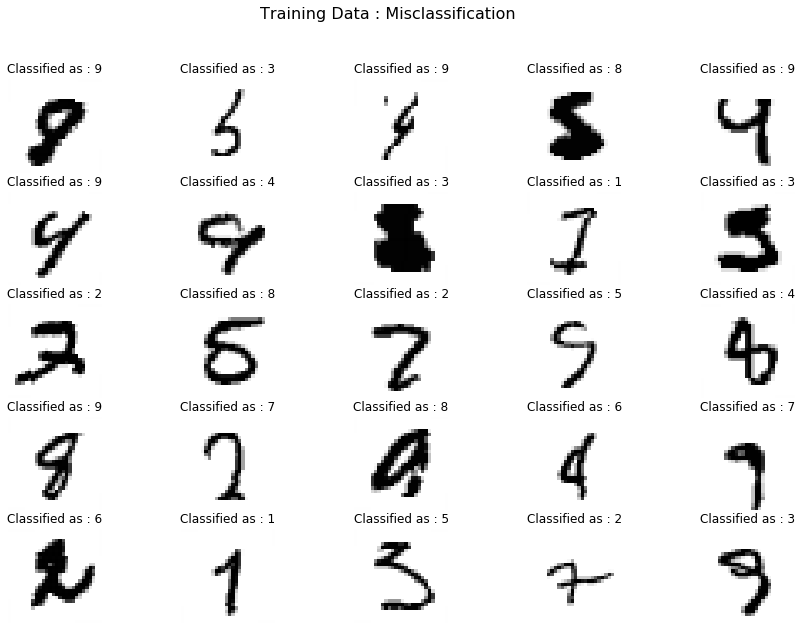

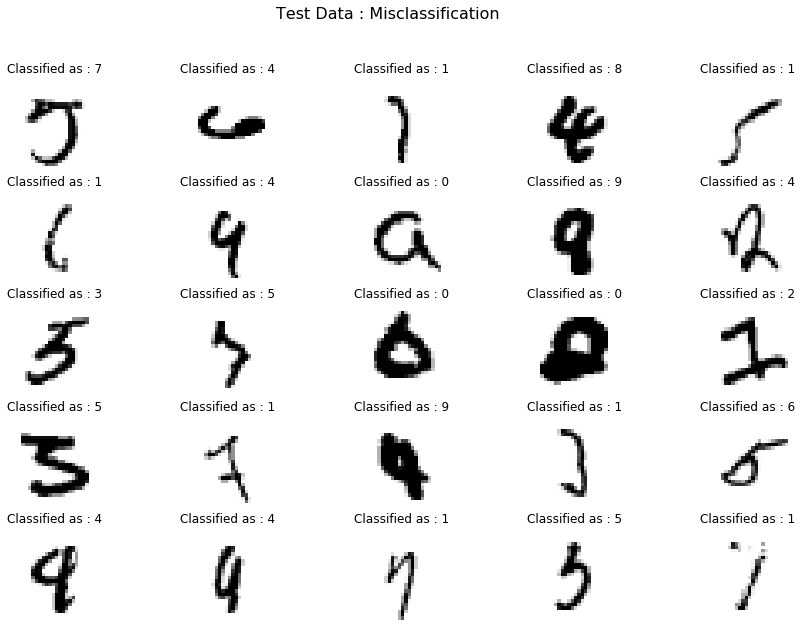

In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'NO_L1_L2')
    # scheduler.step()
    test(model, device, test_loader,'NO_L1_L2')

##PLOTTING NO_L1_L2

Text(0.5, 1.0, 'Test Accuracy')

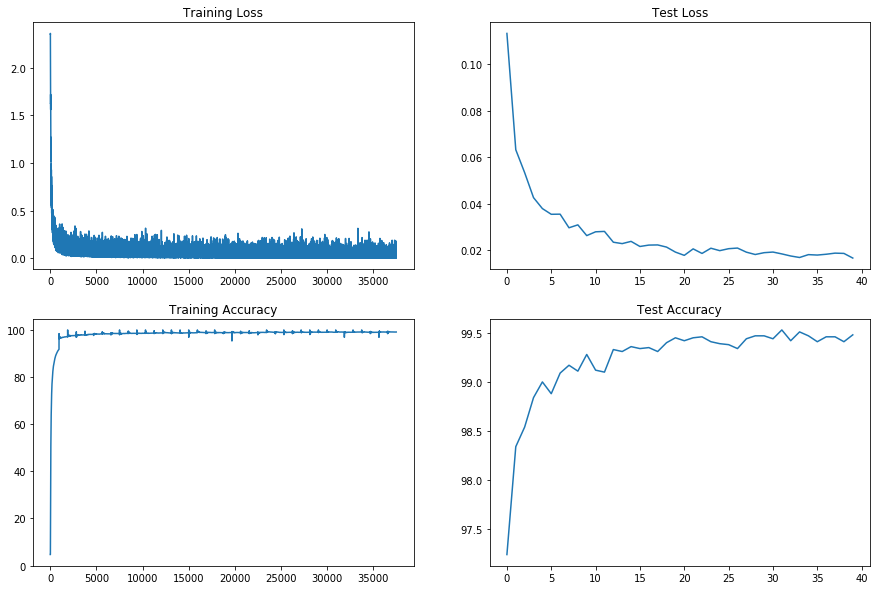

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

##Let's Train and test L1 model

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.4784592390060425 Batch_id=937 Accuracy=91.54: 100%|██████████| 938/938 [00:22<00:00, 41.45it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1183, Accuracy: 9705/10000 (97.05%)

EPOCH: 1


Loss=0.24962033331394196 Batch_id=937 Accuracy=96.85: 100%|██████████| 938/938 [00:23<00:00, 40.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9789/10000 (97.89%)

EPOCH: 2


Loss=0.2155190408229828 Batch_id=937 Accuracy=97.17: 100%|██████████| 938/938 [00:22<00:00, 41.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9823/10000 (98.23%)

EPOCH: 3


Loss=0.19608208537101746 Batch_id=937 Accuracy=97.39: 100%|██████████| 938/938 [00:22<00:00, 41.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9824/10000 (98.24%)

EPOCH: 4


Loss=0.4304901361465454 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:23<00:00, 40.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0865, Accuracy: 9750/10000 (97.50%)

EPOCH: 5


Loss=0.369151771068573 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:22<00:00, 49.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9850/10000 (98.50%)

EPOCH: 6


Loss=0.1882462203502655 Batch_id=937 Accuracy=97.47: 100%|██████████| 938/938 [00:22<00:00, 50.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9819/10000 (98.19%)

EPOCH: 7


Loss=0.35577166080474854 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:22<00:00, 41.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Accuracy: 9761/10000 (97.61%)

EPOCH: 8


Loss=0.21382930874824524 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:22<00:00, 41.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9821/10000 (98.21%)

EPOCH: 9


Loss=0.19347397983074188 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:22<00:00, 41.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9865/10000 (98.65%)

EPOCH: 10


Loss=0.2440360188484192 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:22<00:00, 41.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9866/10000 (98.66%)

EPOCH: 11


Loss=0.3163480758666992 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:22<00:00, 49.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9853/10000 (98.53%)

EPOCH: 12


Loss=0.31233689188957214 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:22<00:00, 41.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9818/10000 (98.18%)

EPOCH: 13


Loss=0.23488128185272217 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:22<00:00, 40.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9839/10000 (98.39%)

EPOCH: 14


Loss=0.2149791270494461 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:22<00:00, 41.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9895/10000 (98.95%)

EPOCH: 15


Loss=0.17844131588935852 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:22<00:00, 49.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9827/10000 (98.27%)

EPOCH: 16


Loss=0.2429155707359314 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:22<00:00, 41.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0820, Accuracy: 9761/10000 (97.61%)

EPOCH: 17


Loss=0.19148722290992737 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:22<00:00, 41.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9804/10000 (98.04%)

EPOCH: 18


Loss=0.17740780115127563 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:22<00:00, 50.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 9794/10000 (97.94%)

EPOCH: 19


Loss=0.15163642168045044 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:22<00:00, 41.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 9823/10000 (98.23%)

EPOCH: 20


Loss=0.2182616889476776 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:22<00:00, 41.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9836/10000 (98.36%)

EPOCH: 21


Loss=0.21792082488536835 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:22<00:00, 41.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0675, Accuracy: 9781/10000 (97.81%)

EPOCH: 22


Loss=0.2621329426765442 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:22<00:00, 42.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0677, Accuracy: 9800/10000 (98.00%)

EPOCH: 23


Loss=0.15474079549312592 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:22<00:00, 41.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9856/10000 (98.56%)

EPOCH: 24


Loss=0.17576859891414642 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:22<00:00, 42.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9800/10000 (98.00%)

EPOCH: 25


Loss=0.33576399087905884 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:22<00:00, 42.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Accuracy: 9790/10000 (97.90%)

EPOCH: 26


Loss=0.16513338685035706 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:22<00:00, 41.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9819/10000 (98.19%)

EPOCH: 27


Loss=0.2722286283969879 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:22<00:00, 48.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9858/10000 (98.58%)

EPOCH: 28


Loss=0.44408118724823 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:22<00:00, 41.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0769, Accuracy: 9772/10000 (97.72%)

EPOCH: 29


Loss=0.17554427683353424 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:22<00:00, 41.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9854/10000 (98.54%)

EPOCH: 30


Loss=0.22368863224983215 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:23<00:00, 40.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0693, Accuracy: 9797/10000 (97.97%)

EPOCH: 31


Loss=0.16791070997714996 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:22<00:00, 40.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9789/10000 (97.89%)

EPOCH: 32


Loss=0.20912837982177734 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:22<00:00, 41.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9861/10000 (98.61%)

EPOCH: 33


Loss=0.29642990231513977 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:23<00:00, 40.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9789/10000 (97.89%)

EPOCH: 34


Loss=0.24862687289714813 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:22<00:00, 41.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0813, Accuracy: 9754/10000 (97.54%)

EPOCH: 35


Loss=0.2356538474559784 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:22<00:00, 41.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0861, Accuracy: 9722/10000 (97.22%)

EPOCH: 36


Loss=0.18626351654529572 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:22<00:00, 49.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9839/10000 (98.39%)

EPOCH: 37


Loss=0.17823992669582367 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:22<00:00, 41.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9881/10000 (98.81%)

EPOCH: 38


Loss=0.16805614531040192 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:22<00:00, 40.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0705, Accuracy: 9786/10000 (97.86%)

EPOCH: 39


Loss=0.29532045125961304 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:23<00:00, 40.60it/s]



Test set: Average loss: 0.0666, Accuracy: 9799/10000 (97.99%)



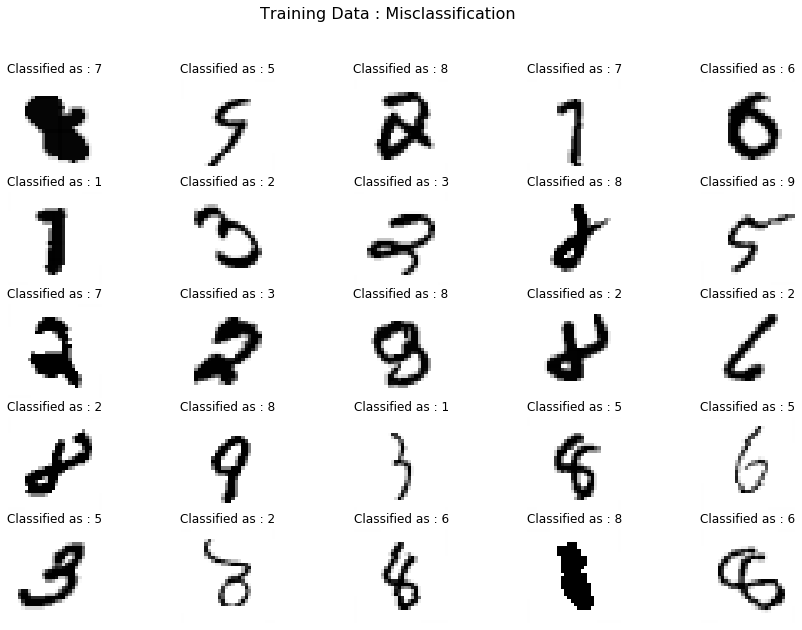

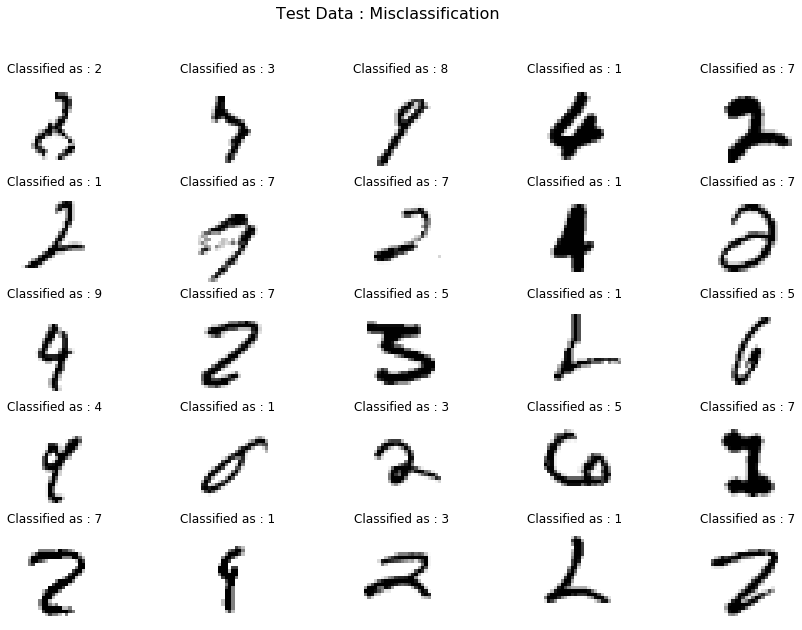

In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'L1')
    # scheduler.step()
    test(model, device, test_loader,'L1')

##PLOTTING L1

Text(0.5, 1.0, 'Test Accuracy')

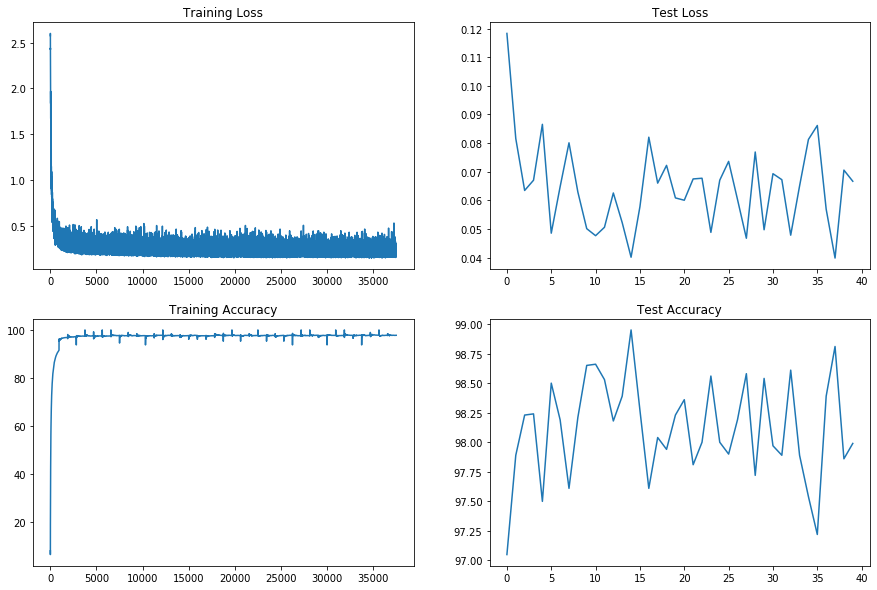

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_L1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_L1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_L1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_L1)
axs[1, 1].set_title("Test Accuracy")

##Testing and Training Model L2

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.18728192150592804 Batch_id=937 Accuracy=92.28: 100%|██████████| 938/938 [00:20<00:00, 45.89it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1139, Accuracy: 9731/10000 (97.31%)

EPOCH: 1


Loss=0.1056308001279831 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [00:20<00:00, 46.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 9827/10000 (98.27%)

EPOCH: 2


Loss=0.06894165277481079 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:20<00:00, 44.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.2920747995376587 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:20<00:00, 46.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.051834918558597565 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:19<00:00, 47.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.08923884481191635 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:19<00:00, 47.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9858/10000 (98.58%)

EPOCH: 6


Loss=0.09084169566631317 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:20<00:00, 45.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9894/10000 (98.94%)

EPOCH: 7


Loss=0.03718251734972 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:20<00:00, 46.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9895/10000 (98.95%)

EPOCH: 8


Loss=0.10469719022512436 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:20<00:00, 46.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9895/10000 (98.95%)

EPOCH: 9


Loss=0.09906508028507233 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:20<00:00, 46.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9874/10000 (98.74%)

EPOCH: 10


Loss=0.0940108597278595 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:20<00:00, 45.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


Loss=0.045372411608695984 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:20<00:00, 46.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9894/10000 (98.94%)

EPOCH: 12


Loss=0.06423579156398773 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:20<00:00, 46.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9886/10000 (98.86%)

EPOCH: 13


Loss=0.13102483749389648 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:20<00:00, 45.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9895/10000 (98.95%)

EPOCH: 14


Loss=0.1162693127989769 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:20<00:00, 53.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9881/10000 (98.81%)

EPOCH: 15


Loss=0.15971589088439941 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:20<00:00, 46.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9884/10000 (98.84%)

EPOCH: 16


Loss=0.29506999254226685 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:20<00:00, 46.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9869/10000 (98.69%)

EPOCH: 17


Loss=0.05104328691959381 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:20<00:00, 45.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9901/10000 (99.01%)

EPOCH: 18


Loss=0.06274066865444183 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:20<00:00, 45.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9889/10000 (98.89%)

EPOCH: 19


Loss=0.10631917417049408 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:20<00:00, 46.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9914/10000 (99.14%)

EPOCH: 20


Loss=0.2170582413673401 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:20<00:00, 46.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9908/10000 (99.08%)

EPOCH: 21


Loss=0.019184887409210205 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:20<00:00, 46.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9892/10000 (98.92%)

EPOCH: 22


Loss=0.19820258021354675 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:23<00:00, 39.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9913/10000 (99.13%)

EPOCH: 23


Loss=0.016164414584636688 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:21<00:00, 43.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9906/10000 (99.06%)

EPOCH: 24


Loss=0.08146067708730698 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:21<00:00, 42.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9906/10000 (99.06%)

EPOCH: 25


Loss=0.04800022393465042 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:21<00:00, 43.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9890/10000 (98.90%)

EPOCH: 26


Loss=0.05626259744167328 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:21<00:00, 43.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9894/10000 (98.94%)

EPOCH: 27


Loss=0.08165447413921356 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:21<00:00, 43.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9899/10000 (98.99%)

EPOCH: 28


Loss=0.08191227912902832 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:21<00:00, 44.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9891/10000 (98.91%)

EPOCH: 29


Loss=0.043474987149238586 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [00:21<00:00, 44.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9887/10000 (98.87%)

EPOCH: 30


Loss=0.07600577175617218 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:20<00:00, 44.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9892/10000 (98.92%)

EPOCH: 31


Loss=0.051603712141513824 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:20<00:00, 44.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9891/10000 (98.91%)

EPOCH: 32


Loss=0.0975145548582077 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:20<00:00, 45.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9886/10000 (98.86%)

EPOCH: 33


Loss=0.24813878536224365 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:20<00:00, 51.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9913/10000 (99.13%)

EPOCH: 34


Loss=0.1404309868812561 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:21<00:00, 44.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9885/10000 (98.85%)

EPOCH: 35


Loss=0.11255990713834763 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:20<00:00, 45.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9881/10000 (98.81%)

EPOCH: 36


Loss=0.02709066867828369 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:21<00:00, 44.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9896/10000 (98.96%)

EPOCH: 37


Loss=0.07241477072238922 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:21<00:00, 43.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9882/10000 (98.82%)

EPOCH: 38


Loss=0.15631750226020813 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:21<00:00, 43.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9911/10000 (99.11%)

EPOCH: 39


Loss=0.048420801758766174 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:21<00:00, 42.92it/s]



Test set: Average loss: 0.0475, Accuracy: 9882/10000 (98.82%)



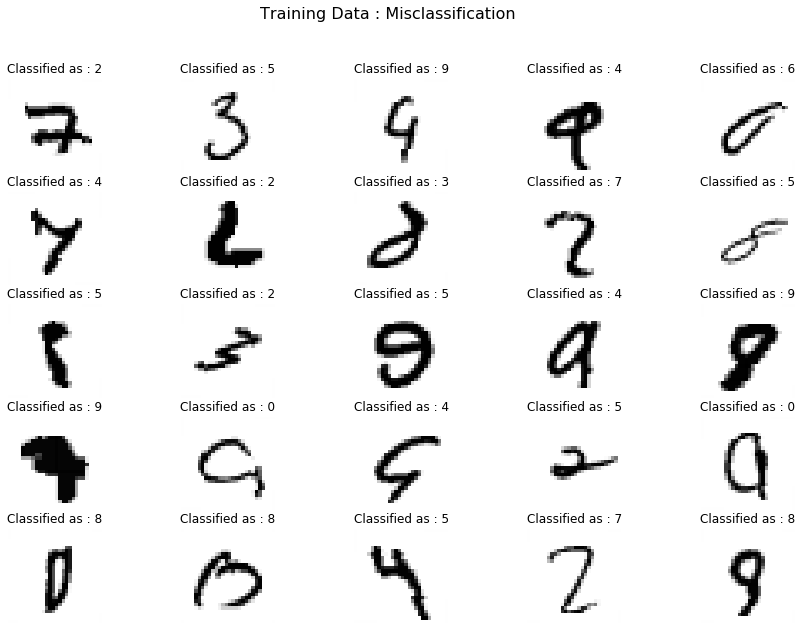

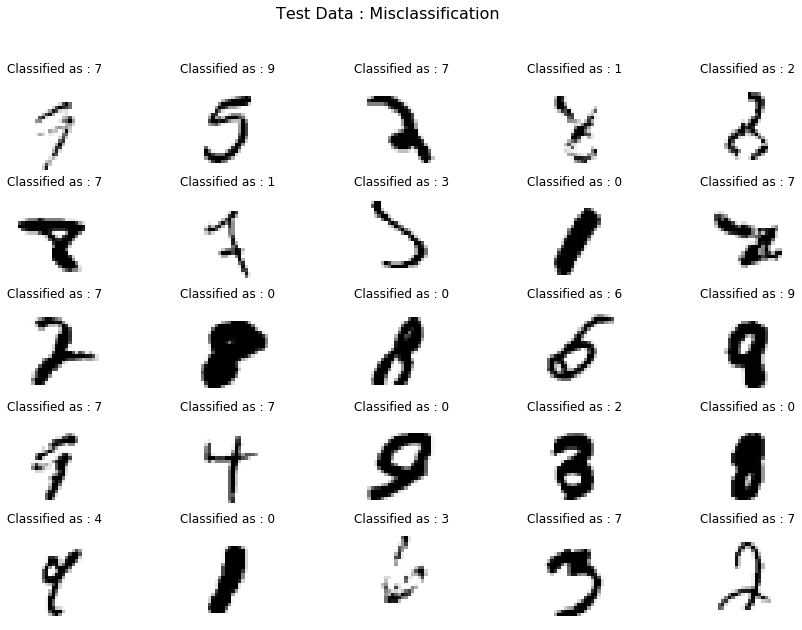

In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay=0.001)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'L2')
    # scheduler.step()
    test(model, device, test_loader,'L2')

##Plotting Model L2

Text(0.5, 1.0, 'Test Accuracy')

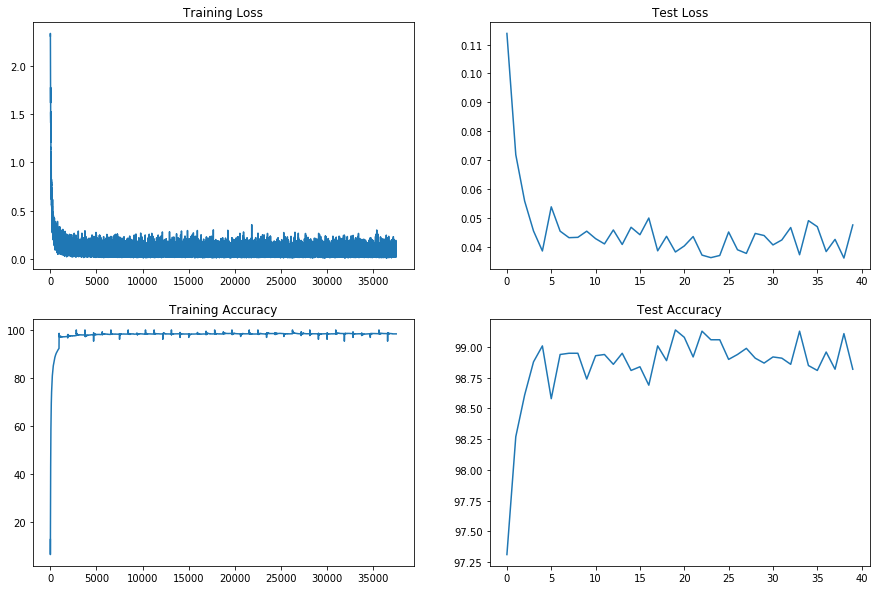

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_L2)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_L2)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_L2)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_L2)
axs[1, 1].set_title("Test Accuracy")

##Testing and Training Model L1_L2

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.39920082688331604 Batch_id=937 Accuracy=91.33: 100%|██████████| 938/938 [00:23<00:00, 39.29it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1651, Accuracy: 9578/10000 (95.78%)

EPOCH: 1


Loss=0.2321571707725525 Batch_id=937 Accuracy=96.75: 100%|██████████| 938/938 [00:23<00:00, 39.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1022, Accuracy: 9757/10000 (97.57%)

EPOCH: 2


Loss=0.20459681749343872 Batch_id=937 Accuracy=97.09: 100%|██████████| 938/938 [00:23<00:00, 39.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9825/10000 (98.25%)

EPOCH: 3


Loss=0.39237159490585327 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:24<00:00, 38.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0815, Accuracy: 9783/10000 (97.83%)

EPOCH: 4


Loss=0.1813126802444458 Batch_id=937 Accuracy=97.42: 100%|██████████| 938/938 [00:24<00:00, 39.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1060, Accuracy: 9711/10000 (97.11%)

EPOCH: 5


Loss=0.24425756931304932 Batch_id=937 Accuracy=97.44: 100%|██████████| 938/938 [00:24<00:00, 38.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0817, Accuracy: 9791/10000 (97.91%)

EPOCH: 6


Loss=0.3073008358478546 Batch_id=937 Accuracy=97.44: 100%|██████████| 938/938 [00:23<00:00, 39.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0999, Accuracy: 9765/10000 (97.65%)

EPOCH: 7


Loss=0.25577908754348755 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:23<00:00, 39.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0928, Accuracy: 9742/10000 (97.42%)

EPOCH: 8


Loss=0.2164153754711151 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [00:23<00:00, 39.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0740, Accuracy: 9809/10000 (98.09%)

EPOCH: 9


Loss=0.29442036151885986 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [00:23<00:00, 39.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1450, Accuracy: 9575/10000 (95.75%)

EPOCH: 10


Loss=0.33874160051345825 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:23<00:00, 39.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9846/10000 (98.46%)

EPOCH: 11


Loss=0.25790685415267944 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [00:23<00:00, 40.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1063, Accuracy: 9724/10000 (97.24%)

EPOCH: 12


Loss=0.18511764705181122 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:23<00:00, 39.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9795/10000 (97.95%)

EPOCH: 13


Loss=0.24020977318286896 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:23<00:00, 39.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0940, Accuracy: 9775/10000 (97.75%)

EPOCH: 14


Loss=0.320345938205719 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:23<00:00, 40.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0974, Accuracy: 9769/10000 (97.69%)

EPOCH: 15


Loss=0.3107469081878662 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:23<00:00, 39.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0895, Accuracy: 9788/10000 (97.88%)

EPOCH: 16


Loss=0.20129841566085815 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:23<00:00, 46.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0819, Accuracy: 9777/10000 (97.77%)

EPOCH: 17


Loss=0.21114087104797363 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:24<00:00, 37.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0980, Accuracy: 9750/10000 (97.50%)

EPOCH: 18


Loss=0.21036642789840698 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:23<00:00, 45.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0625, Accuracy: 9850/10000 (98.50%)

EPOCH: 19


Loss=0.22178536653518677 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:24<00:00, 37.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1250, Accuracy: 9653/10000 (96.53%)

EPOCH: 20


Loss=0.15404660999774933 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:24<00:00, 38.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1133, Accuracy: 9676/10000 (96.76%)

EPOCH: 21


Loss=0.3518780767917633 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:25<00:00, 37.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0920, Accuracy: 9779/10000 (97.79%)

EPOCH: 22


Loss=0.30569586157798767 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:24<00:00, 38.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Accuracy: 9779/10000 (97.79%)

EPOCH: 23


Loss=0.20774953067302704 Batch_id=937 Accuracy=97.48: 100%|██████████| 938/938 [00:24<00:00, 38.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0867, Accuracy: 9770/10000 (97.70%)

EPOCH: 24


Loss=0.257423996925354 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:23<00:00, 39.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9874/10000 (98.74%)

EPOCH: 25


Loss=0.2657685875892639 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:23<00:00, 47.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0742, Accuracy: 9802/10000 (98.02%)

EPOCH: 26


Loss=0.20000021159648895 Batch_id=937 Accuracy=97.57: 100%|██████████| 938/938 [00:24<00:00, 38.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0751, Accuracy: 9793/10000 (97.93%)

EPOCH: 27


Loss=0.332043319940567 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:23<00:00, 46.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0821, Accuracy: 9790/10000 (97.90%)

EPOCH: 28


Loss=0.3179008960723877 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:24<00:00, 38.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1076, Accuracy: 9716/10000 (97.16%)

EPOCH: 29


Loss=0.2605218291282654 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:23<00:00, 45.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0971, Accuracy: 9708/10000 (97.08%)

EPOCH: 30


Loss=0.17422835528850555 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:24<00:00, 38.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9839/10000 (98.39%)

EPOCH: 31


Loss=0.3351498246192932 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:23<00:00, 45.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0983, Accuracy: 9730/10000 (97.30%)

EPOCH: 32


Loss=0.2831505835056305 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:24<00:00, 38.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 9755/10000 (97.55%)

EPOCH: 33


Loss=0.22644037008285522 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:24<00:00, 37.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0983, Accuracy: 9749/10000 (97.49%)

EPOCH: 34


Loss=0.39358019828796387 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:23<00:00, 48.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9832/10000 (98.32%)

EPOCH: 35


Loss=0.1965937316417694 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:24<00:00, 38.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0986, Accuracy: 9738/10000 (97.38%)

EPOCH: 36


Loss=0.23156210780143738 Batch_id=937 Accuracy=97.59: 100%|██████████| 938/938 [00:24<00:00, 38.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0916, Accuracy: 9764/10000 (97.64%)

EPOCH: 37


Loss=0.2850603759288788 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:24<00:00, 38.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1129, Accuracy: 9704/10000 (97.04%)

EPOCH: 38


Loss=0.23295852541923523 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:23<00:00, 47.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0698, Accuracy: 9861/10000 (98.61%)

EPOCH: 39


Loss=0.2553313374519348 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:24<00:00, 45.60it/s]



Test set: Average loss: 0.0757, Accuracy: 9824/10000 (98.24%)



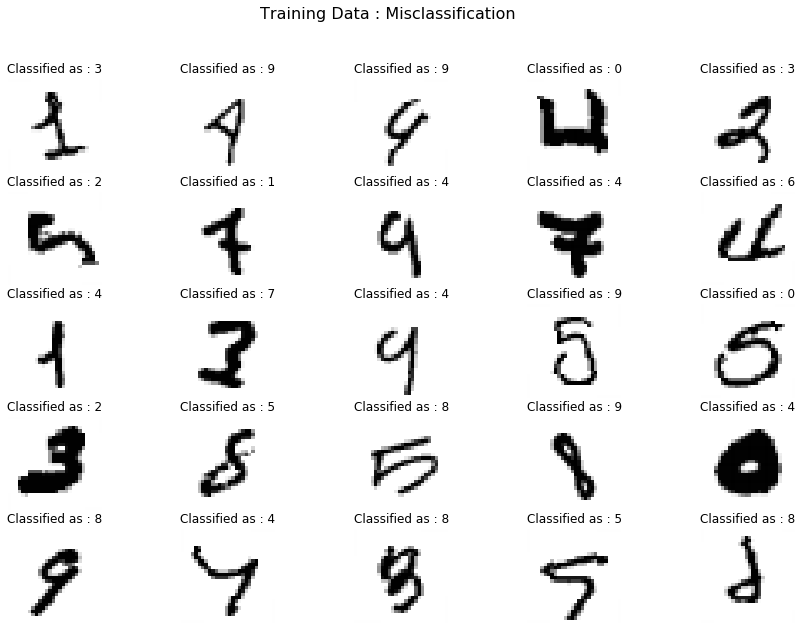

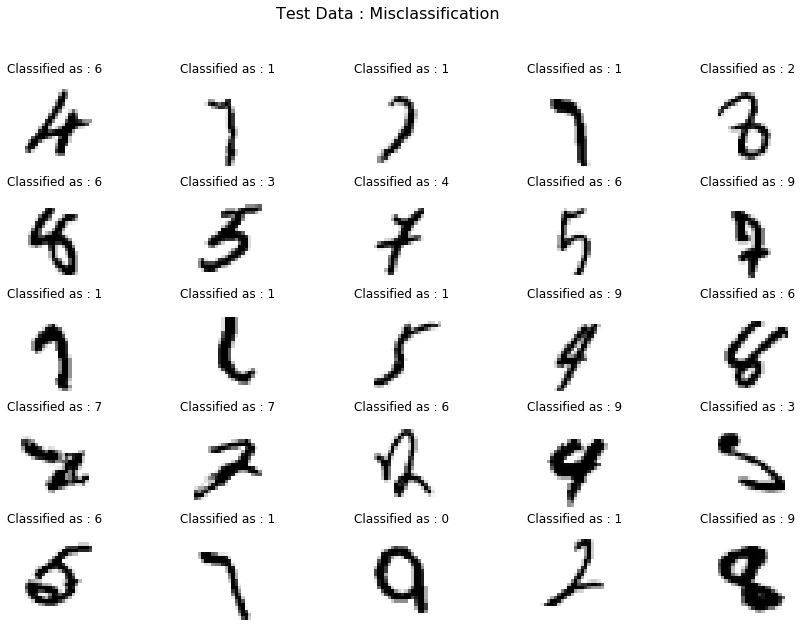

In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay=0.001)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,'L1_L2')
    # scheduler.step()
    test(model, device, test_loader,'L1_L2')

##Matplot L1_L2

Text(0.5, 1.0, 'Test Accuracy')

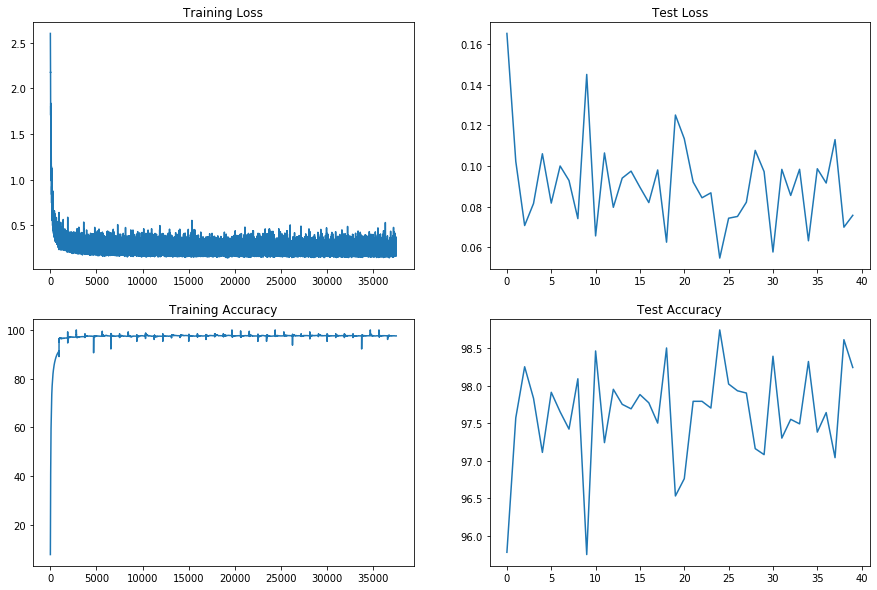

In [0]:

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_L1_L2)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_L1_L2)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_L1_L2)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_L1_L2)
axs[1, 1].set_title("Test Accuracy")

## Plotting All Models Test Accuracy and Test Losses

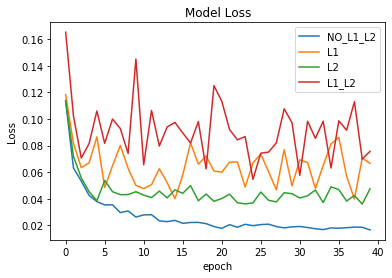

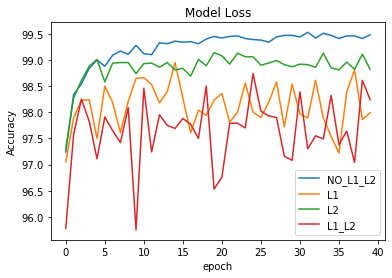

In [0]:
plt.plot(test_losses)
plt.plot(test_losses_L1)
plt.plot(test_losses_L2)
plt.plot(test_losses_L1_L2)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['NO_L1_L2','L1','L2','L1_L2'],loc='best')
plt.show()

plt.plot(test_acc)
plt.plot(test_acc_L1)
plt.plot(test_acc_L2)
plt.plot(test_acc_L1_L2)

plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['NO_L1_L2','L1','L2','L1_L2'],loc='best')

plt.show()